<a href="https://colab.research.google.com/github/AmandinChyba/Project1-Fields-2022/blob/main/Deep_Learning/wobNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install -q git+https://github.com/deepmind/dm-haiku
#!pip install -q optax

haiku documentation: https://dm-haiku.readthedocs.io/en/latest/api.html

optax documentation: https://jax.readthedocs.io/en/latest/jax.example_libraries.optimizers.html

tutorial: https://coderzcolumn.com/tutorials/artificial-intelligence/haiku-guide-to-create-multi-layer-perceptrons-using-jax

haiku example: https://github.com/deepmind/dm-haiku/blob/main/examples/mnist.py 

In [ ]:
import haiku as hk
import optax
import jax.numpy as jnp
import numpy as np
import jax
import jax.lax as lax

from typing import NamedTuple

# Data

In [ ]:
def getData():
  data = np.load('drive/MyDrive/wob_piecwise_data.npz')
  return data['x'], data['y']

In [ ]:
def test_train_split(x, y):
  x = jnp.array(x)
  y = jnp.array(y)

  sample_size, dimensions = x.shape

  train_percentage = 0.8
  split_index = int(jnp.ceil(sample_size * train_percentage))

  x_train = x[:split_index]
  y_train = y[:split_index]
  x_test = x[split_index:]
  y_test = y[split_index:]

  return x_train, y_train, x_test, y_test

In [ ]:
def fast_data(x_train, y_train, epochs=1, batch_size=1):
  x_train_fast, y_train_fast = x_train, y_train

  extra = len(x_train_fast) % batch_size
  if extra != 0:
    x_train_fast = x_train_fast[:-extra]
    y_train_fast = y_train_fast[:-extra]

  batches = int(len(x_train_fast)/batch_size)
  x_train_fast = jnp.reshape(x_train_fast, (batches, batch_size, jnp.size(x_train_fast, 1)))
  y_train_fast = jnp.reshape(y_train_fast, (batches, batch_size, 1))

  x_train_fast = jnp.tile(x_train_fast, (epochs,1,1))
  y_train_fast = jnp.tile(y_train_fast, (epochs,1,1))
  return x_train_fast, y_train_fast

In [ ]:
x, y = getData()
x_train, y_train, x_test, y_test = test_train_split(x, y)

# Network

In [ ]:
def netFn(x):
  mlp = hk.Sequential([
      hk.Flatten(),
      hk.Linear(50), jax.nn.relu,
      hk.Linear(10), jax.nn.relu,
      hk.Linear(1),
  ])
  return mlp(x)

In [ ]:
lr = 1e-3
key = jax.random.PRNGKey(0)

network = hk.without_apply_rng(hk.transform(netFn))
optimizer = optax.adam(lr)

In [ ]:
params = network.init(key, x_train[0])
opt_state = optimizer.init(params)

In [ ]:
@jax.jit
def predict(params, input_data):
  preds = network.apply(params, input_data)
  return preds

In [ ]:
@jax.jit
def loss(params, input_data, actual):
  preds = predict(params, input_data)
  return jnp.power(actual - preds, 2).mean()

In [ ]:
@jax.jit
def update(params, opt_state, input_data, actual_data):
  loss_value, grads = jax.value_and_grad(loss, 0)(params, input_data, actual_data)
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  return loss_value, params, opt_state

# Training

In [ ]:
def training_scan_loop(state, input_data):
  train_loss, params, opt_state = update(state[0], state[1], input_data[0], input_data[1])
  #return (params, opt_state), train_loss
  test_loss = loss(state[0], x_test, y_test)
  return (params, opt_state), (train_loss, test_loss)

In [ ]:
@jax.jit
def train_fast(params, opt_state, x_train_fast, y_train_fast):
  init_state = (params, opt_state)
  input_data = (x_train_fast, y_train_fast)
  final_state, loss_array = lax.scan(training_scan_loop, init_state, input_data)
  return final_state[0], final_state[1], loss_array

def train_normal(params, opt_state, epochs, batch_size):
  for i in range(epochs):
    for j in range(0, len(x_train), batch_size):
      train_loss, params, opt_state = update(params, opt_state, 
                                             x_train[j:j+batch_size], 
                                             y_train[j:j+batch_size])
    if (i % 100 == 0):
      test_loss = loss(params, x_test, y_test)
      print('loss:', test_loss)
  return params, opt_state

In [ ]:
%%time
#params, opt_state = train_normal(params, opt_state, epochs=500, batch_size=100)

In [ ]:
%%time
epochs = 500
batch_size = 100
x_train_fast, y_train_fast = fast_data(x_train, y_train, epochs, batch_size)
params, opt_state, loss_array = train_fast(params, opt_state, x_train_fast, y_train_fast)

CPU times: user 6.36 s, sys: 8.68 ms, total: 6.37 s
Wall time: 6.36 s


# Loss

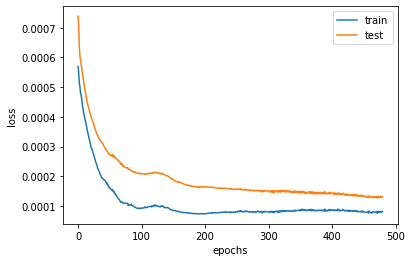

In [ ]:
epoch_start = 20
batches_per_epoch = int(len(loss_array[0]) / epochs)

epoch_axis = jnp.arange(epochs-epoch_start)
train_loss = loss_array[0][::batches_per_epoch][epoch_start:]
test_loss = loss_array[1][::batches_per_epoch][epoch_start:]


plt.plot(epoch_axis, train_loss, label='train')
plt.plot(epoch_axis, test_loss, label='test')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

# Error

In [ ]:
def trueSoln(p):
  return 0.5 + np.arctan(2*p[1]/(1-np.power(p[0],2)-np.power(p[1],2)))/np.pi

mean 0.005565622
std 0.007825293
median 0.0041312575


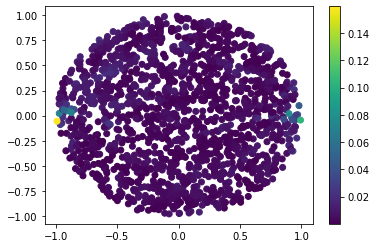

In [ ]:
import matplotlib.pyplot as plt

error = jnp.abs(predict(params, x_test) - trueSoln(x_test.T).reshape((-1,1)))
print('mean', error.mean())
print('std', error.std())
print('median', jnp.median(error))

plt.scatter(x_test[:,0], x_test[:,1], c=error)
plt.colorbar()

mean 0.007626235
std 0.008571555
median 0.0060768127


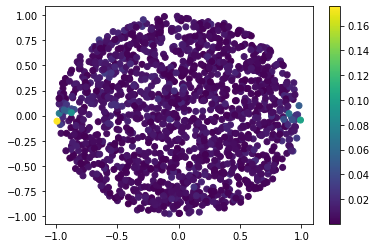

In [ ]:
error = jnp.abs(predict(params, x_test) - y_test)
print('mean', error.mean())
print('std', error.std())
print('median', jnp.median(error))

plt.scatter(x_test[:,0], x_test[:,1], c=error)
plt.colorbar()

mean 0.0047628027
std 0.0036320835
median 0.00396125


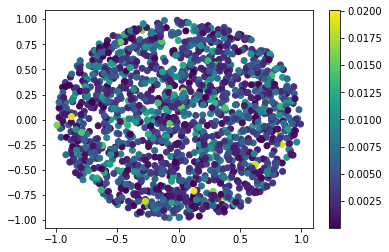

In [ ]:
error = jnp.abs(trueSoln(x_test.T).reshape((-1,1)) - y_test)
print('mean', error.mean())
print('std', error.std())
print('median', jnp.median(error))

plt.scatter(x_test[:,0], x_test[:,1], c=error)
plt.colorbar()